In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

from importlib import reload  

import sys, os


current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

In [2]:

### ----------------------------------------------
#   FUNCTIONALITIES FOR PLOTTING
#

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import matplotlib.cm as cm

        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='', max_eta=0.0, max_huv=0.0):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625

    if max_eta > 0.0:
        eta_max = max_eta
    if max_huv > 0.0:
        huv_max = max_huv
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    extent = None

    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    axs[0].set_ylabel("...", labelpad=3, fontsize=fontsize)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    


/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  del sys.path[0]


In [3]:
# For GPU contex:
from SWESimulators import Common

# Create CUDA context
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()

In [4]:
from SWESimulators import DoubleJetCase

doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

Small scale error checks

In [5]:
noise_args = {}
noise_args["soar_q0"] = doubleJetCase_args["small_scale_perturbation_amplitude"]
noise_args["interpolation_factor"] = doubleJetCase_args["small_scale_perturbation_interpolation_factor"]
noise_args["block_width"] = 16
noise_args["block_height"] = 16
noise_args["use_lcg"] = True
noise_args["xorwow_seed"] = None


In [6]:
from SWESimulators import CDKLM16

In [7]:
sim = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
eta_before, hu_before, hv_before = sim.download()

In [8]:
from SWESimulators import OceanStateNoise

In [9]:
small_scale_model_error = OceanStateNoise.OceanStateNoise.fromsim(sim, **noise_args)

In [10]:
small_scale_model_error.perturbSim(sim)

In [11]:
eta_after, hu_after, hv_after = sim.download()

In [12]:
np.sum(eta_before == eta_after)

3233

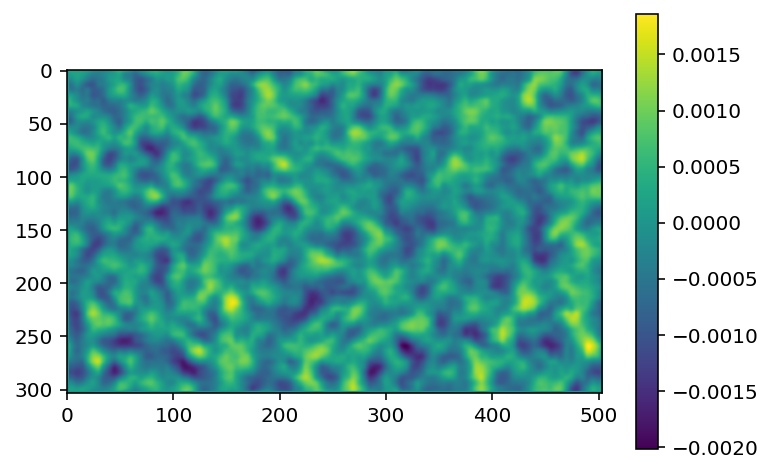

In [13]:
plt.imshow(eta_after-eta_before)
plt.colorbar()

Creating a single stochastic simulation (with seed)

In [14]:
sim = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, xorwow_seed=1)
sim.dataAssimilationStep(72*60*60, write_now=False)

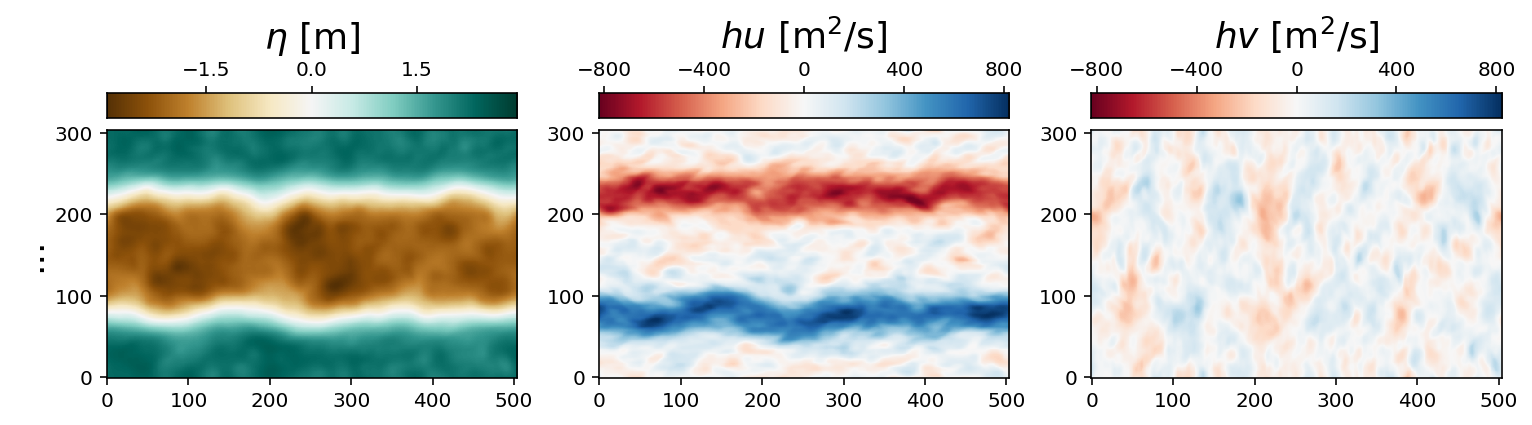

In [15]:
eta, hu, hv = sim.download()
imshow3(eta, hu, hv)

In [16]:
sim_check = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, xorwow_seed=1)
sim_check.dataAssimilationStep(72*60*60, write_now=False)

In [17]:
eta_check, hu_check, hv_check = sim_check.download()
np.sum(eta == eta_check)

153216

In [18]:
304*504

153216

In [19]:
sim_unseeded = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, use_lcg=False)
sim_unseeded.dataAssimilationStep(72*60*60, write_now=False)

In [20]:
eta_unseeded, hu_unseeded, hv_unseeded = sim_unseeded.download()
np.sum(eta == eta_unseeded)

0

In [21]:
sim_wrong = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, xorwow_seed=2)
sim_wrong.dataAssimilationStep(72*60*60, write_now=False)


In [22]:
eta_wrong, hu_wrong, hv_wrong = sim_wrong.download()
np.sum(eta == eta_wrong)

0

In [23]:
sim_lcg = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init, use_lcg=True)
sim_lcg.dataAssimilationStep(72*60*60, write_now=False)


In [24]:
eta_lcg, hu_lcg, hv_lcg = sim_lcg.download()
np.sum(eta == eta_lcg)

0

In [25]:
randomState = np.random.RandomState()
randomState.seed(0)

In [26]:
randomState.rand(3,5)

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
       [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
       [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606]])

In [27]:
from SWESimulators import OceanStateNoise
reload(OceanStateNoise)

smallScalePerturbation = OceanStateNoise.OceanStateNoise.fromsim(sim, use_lcg=True)

In [28]:
smallScalePerturbation.getSeed().shape

(300, 250)

In [29]:
smallScalePerturbation.getRandomNumbers()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [89]:
import pycuda
import pycuda.gpuarray
import pycuda.driver as cuda
from pycuda.curandom import seed_getter_uniform
from pycuda.curandom import XORWOWRandomNumberGenerator

def set_seeder(N, seed):
    seedarr = pycuda.gpuarray.ones_like(pycuda.gpuarray.zeros(N, dtype=np.int32), dtype=np.int32) * seed
    return seedarr

seed = 12346

rng = XORWOWRandomNumberGenerator( lambda N: set_seeder(N,seed) )

In [90]:
width = 300
height = 500

In [91]:
random_numbers_host = np.zeros((np.int32(width), np.int32(height)), dtype=np.float32, order='C')
random_numbers = Common.CUDAArray2D(sim.gpu_stream, np.int32(height), np.int32(width), 0, 0, random_numbers_host)

In [92]:
rng.fill_normal(random_numbers.data, stream=sim.gpu_stream)

In [93]:
random_numbers.download(sim.gpu_stream)


array([[ 0.65762734,  0.7507866 , -0.14282309, ...,  0.03024454,
        -0.07589561, -0.85445666],
       [ 0.8846035 , -1.7202446 , -0.23483527, ...,  0.69043547,
        -0.9383488 , -0.821777  ],
       [ 0.02983409,  0.272571  ,  0.28942227, ..., -1.3983182 ,
         0.5100958 , -1.817062  ],
       ...,
       [ 0.537429  , -2.2680295 ,  0.10241966, ...,  0.8282112 ,
        -0.7961329 ,  1.9848778 ],
       [ 0.91223127,  0.5267706 , -0.70965666, ...,  0.827634  ,
        -0.8771468 , -0.3192788 ],
       [ 3.0986917 , -1.0505686 ,  0.33359808, ..., -0.8543773 ,
         0.8474264 , -0.307431  ]], dtype=float32)

(array([4.0000e+00, 3.0000e+00, 1.3000e+01, 1.0000e+01, 2.9000e+01,
        4.2000e+01, 6.3000e+01, 1.8100e+02, 2.5700e+02, 4.3000e+02,
        6.4200e+02, 9.9800e+02, 1.4130e+03, 1.9320e+03, 2.6040e+03,
        3.5720e+03, 4.3400e+03, 5.5000e+03, 6.6940e+03, 7.7560e+03,
        8.9550e+03, 9.5390e+03, 1.0173e+04, 1.0708e+04, 1.0392e+04,
        1.0125e+04, 9.6180e+03, 8.7490e+03, 7.5180e+03, 6.4520e+03,
        5.2960e+03, 4.4680e+03, 3.3110e+03, 2.5430e+03, 1.8680e+03,
        1.3560e+03, 9.4900e+02, 5.8900e+02, 3.8300e+02, 2.0900e+02,
        1.2900e+02, 8.6000e+01, 4.5000e+01, 2.5000e+01, 1.6000e+01,
        8.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-4.2158117 , -4.0395904 , -3.8633687 , -3.6871471 , -3.5109255 ,
        -3.3347042 , -3.1584826 , -2.982261  , -2.8060396 , -2.629818  ,
        -2.4535964 , -2.277375  , -2.1011534 , -1.9249318 , -1.7487103 ,
        -1.5724888 , -1.3962672 , -1.2200457 , -1.0438242 , -0.8676026 ,
        -0.6913811 , -0.51

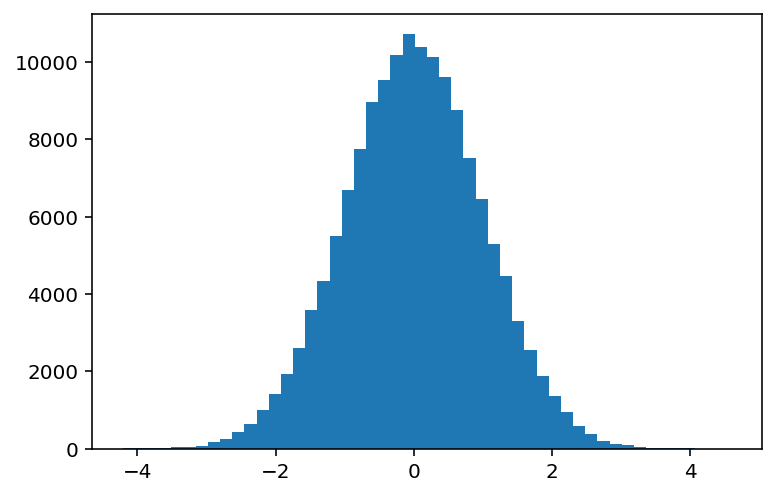

In [94]:
plt.hist(random_numbers.download(sim.gpu_stream).flatten(), bins=50)

In [95]:
np.max(np.corrcoef(random_numbers.download(sim.gpu_stream)) - np.eye(width))

0.20927390087061332

Unseeded

In [96]:
rng_plain = XORWOWRandomNumberGenerator()
rng_plain.fill_normal(random_numbers.data, stream=sim.gpu_stream)
random_numbers.download(sim.gpu_stream)

array([[ 2.319294  , -2.099439  , -0.46164358, ...,  0.9056908 ,
        -0.560598  ,  0.1960442 ],
       [ 0.362659  , -1.0304657 , -1.9368699 , ...,  0.28892908,
         0.3561891 , -0.7421032 ],
       [-0.4217854 , -1.2265222 ,  0.98569274, ..., -0.08212415,
        -0.35842186, -1.8906351 ],
       ...,
       [-0.45256022, -0.81210756, -0.11224273, ..., -0.9211305 ,
         1.3343683 ,  0.45690173],
       [ 0.36359587, -0.4470746 ,  1.6851434 , ..., -0.48449156,
         0.03004225,  0.07242972],
       [ 0.70429397,  0.71346056, -0.314685  , ...,  1.3881646 ,
         2.006382  , -1.6991296 ]], dtype=float32)

(array([3.0000e+00, 3.0000e+00, 3.0000e+00, 6.0000e+00, 1.5000e+01,
        2.6000e+01, 5.5000e+01, 8.5000e+01, 1.5600e+02, 2.6400e+02,
        3.9300e+02, 6.3900e+02, 9.0800e+02, 1.1790e+03, 1.8150e+03,
        2.4660e+03, 3.2650e+03, 4.1500e+03, 5.0340e+03, 5.9660e+03,
        7.2140e+03, 8.0430e+03, 9.1230e+03, 9.8520e+03, 1.0145e+04,
        1.0261e+04, 1.0052e+04, 9.7680e+03, 9.0160e+03, 7.9550e+03,
        7.0410e+03, 5.8780e+03, 4.9140e+03, 3.8930e+03, 3.0230e+03,
        2.2640e+03, 1.6780e+03, 1.1620e+03, 8.2100e+02, 5.5400e+02,
        3.3900e+02, 2.2700e+02, 1.5100e+02, 8.8000e+01, 4.8000e+01,
        3.1000e+01, 1.8000e+01, 4.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([-4.361654  , -4.18993   , -4.0182056 , -3.8464818 , -3.6747577 ,
        -3.5030336 , -3.3313098 , -3.1595857 , -2.9878616 , -2.8161378 ,
        -2.6444137 , -2.4726896 , -2.3009655 , -2.1292417 , -1.9575176 ,
        -1.7857935 , -1.6140696 , -1.4423456 , -1.2706215 , -1.0988976 ,
        -0.9271735 , -0.75

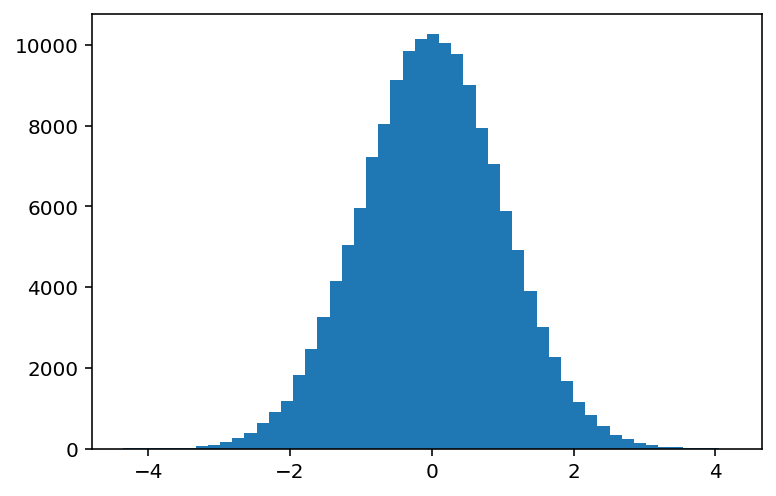

In [97]:
plt.hist(random_numbers.download(sim.gpu_stream).flatten(), bins=50)

In [98]:
np.max(np.corrcoef(random_numbers.download(sim.gpu_stream)) - np.eye(width))

0.20052963834255194